In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

2023-05-31 16:54:20.725224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# fishnets functions

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0))) + jnp.eye(n_params)




class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.swish(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

# load data

In [3]:
pwd

'/home/makinen/repositories/fishnets_for_degenerates/testing_saturation'

In [4]:
data = np.load('camb_TT_secret_params.npy')
theta_ = jax.device_put(data[:, :6])
data = jax.device_put(jnp.arcsinh(data)[:, 6:][:, ::4]) # take every fourth bin (for now)

In [7]:
specshape = data.shape[-1]

data.shape, theta_.shape

((10000, 513), (10000, 6))

In [60]:
key = jax.random.PRNGKey(0)

n_params = 6
n_outputs = int(n_params + int(n_params * (n_params + 1)) // 2)

theta_fid = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

model = MLP([1024,500,128,n_outputs])

outs = model.apply(w, jnp.ones((specshape)))

In [61]:
outs.shape

(27,)

In [62]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       outputs = model.apply(w, x)
       t = outputs[:n_params]
       f_cholesky = outputs[n_params:]
       F = construct_fisher_matrix_single(f_cholesky)

       # score jump step
       mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

       return mle, F
    
    mle,F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [80]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 100
epochs = 100


# initialize several different networks
n_training_data = [500, 1000, 5000, 9500]

# set to same key
model_key = jax.random.PRNGKey(88)
model_weights = [model.init(model_key, jnp.ones((specshape))) for i in n_training_data]


losses = []

In [81]:
# set aside test set
n_test = 500
theta_test = theta_[-n_test:]
data_test = data[-n_test:]

theta_train = theta_[:-n_test]
data_train = data[:-n_test]


In [82]:
theta_train.shape, data_train.shape

((9500, 6), (9500, 513))

In [83]:
def body_fun(i, inputs):
    w,loss_val, opt_state = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    
    return w, loss_val, opt_state

training with n_train: 500


epoch 1499 loss: -12.57088: 100%|██████████| 1500/1500 [00:13<00:00, 112.52it/s]


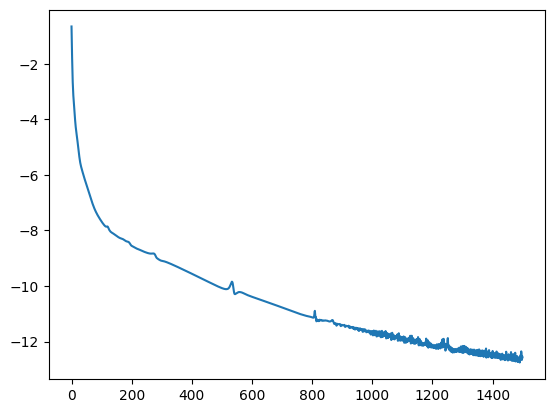

training with n_train: 1000


epoch 1499 loss: -11.49792: 100%|██████████| 1500/1500 [00:17<00:00, 83.91it/s]


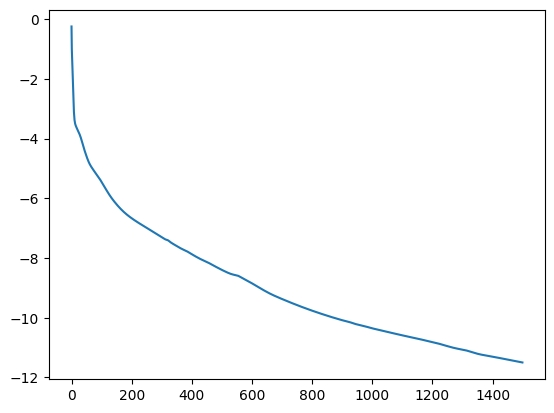

training with n_train: 5000


epoch 1499 loss: -21.07181: 100%|██████████| 1500/1500 [00:52<00:00, 28.45it/s]


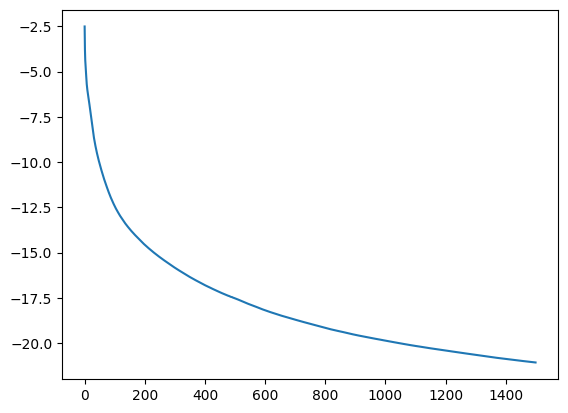

training with n_train: 9500


epoch 1499 loss: -23.12472: 100%|██████████| 1500/1500 [01:31<00:00, 16.34it/s]


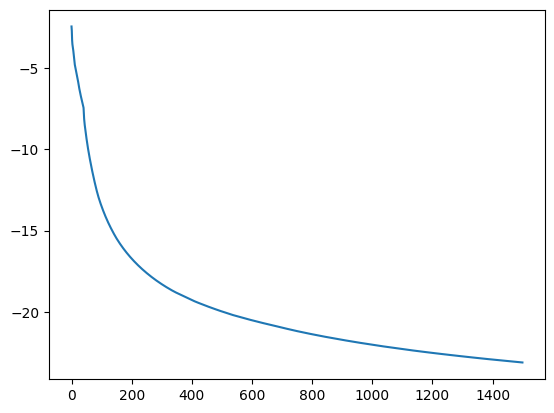

In [84]:
from tqdm import tqdm
#from tqdm.notebook import trange
batch_size = 100
epochs = 1500

batch_size = 100

trained_weights = []
all_losses = []

for i,n_train in enumerate(n_training_data):
    
    w_i = model_weights[i]
    
    print("training with n_train:", n_train)
    idx = np.random.choice(jnp.arange(9500), size=n_train)
    _data = data_train[idx]
    _theta = theta_train[idx]
    
    
    _data = _data.reshape(-1, batch_size, specshape)
    _theta = _theta.reshape(-1, batch_size, 6)


    # keep same batch size but sample different training set sizes every time


    key = jax.random.PRNGKey(999)

    losses = jnp.zeros(epochs)

    loss_val = 0.

    lower = 0
    upper = n_train // batch_size

    pbar = tqdm(range(epochs), leave=True, position=0)

    for j in pbar:
          key,rng = jax.random.split(key)

          # shuffle data every epoch
          #randidx = jax.random.shuffle(key, jnp.arange(_theta.reshape(-1, 6).shape[0]))
          #_data = _data.reshape(-1, specshape)[randidx].reshape(batch_size, -1, specshape)
          #_theta = _theta.reshape(-1, 6)[randidx].reshape(batch_size, -1, 6)

          inits = (w_i, loss_val, opt_state)

          w_i, loss_val, opt_state = jax.lax.fori_loop(lower, upper, body_fun, inits)

          losses = losses.at[j].set(loss_val)
          #val_losses.append(val_loss)
          pbar.set_description('epoch %d loss: %.5f'%(j, loss_val))
            
    plt.plot(losses)
    plt.show()
    
    all_losses.append(losses)
    trained_weights.append(w_i)


In [86]:
def get_mle_F(x, w):
    outputs = model.apply(w, x)
    t = outputs[:n_params]
    f_cholesky = outputs[n_params:]
    F = construct_fisher_matrix_single(f_cholesky)

    mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

    return mle, F

In [87]:
data_test.shape

(500, 513)

In [90]:
mle_preds = []
F_preds = []

for i,w_i in enumerate(trained_weights):
    fn = lambda d: get_mle_F(d, w=w_i)
    mle_pred,F_pred = jax.vmap(fn)(data_test.reshape(-1, specshape)[:])
    
    mle_preds.append(mle_pred)
    F_preds.append(F_pred)

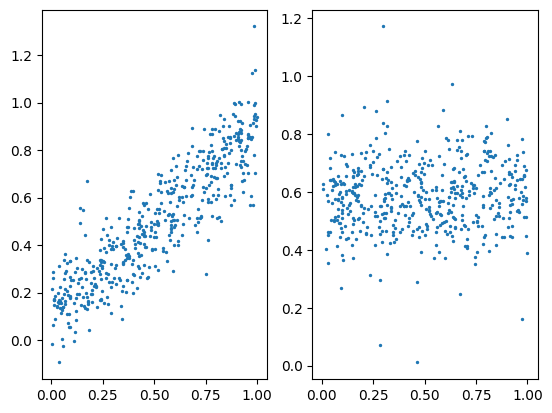

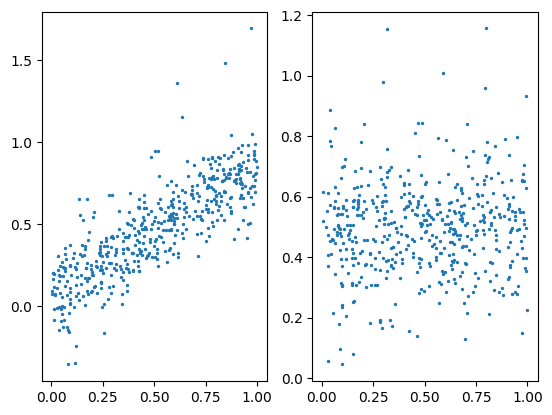

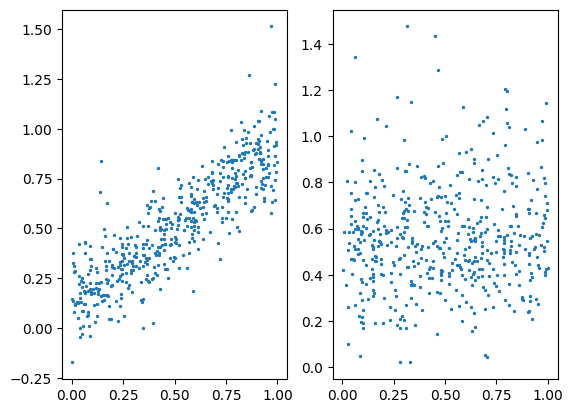

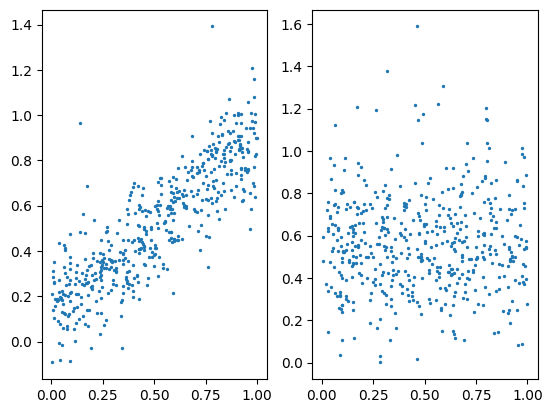

In [91]:
for i,w in enumerate(model_weights):
    plt.subplot(121)
    plt.scatter(theta_test.reshape(-1,6)[:, 0], mle_preds[i][:, 0], s=2)
    plt.subplot(122)
    plt.scatter(theta_test.reshape(-1,6)[:, 3], mle_preds[i][:, 3], s=2)
    plt.show()

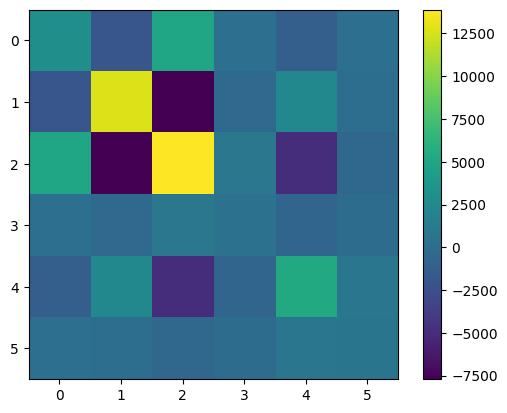

In [72]:
plt.imshow(F_pred.mean(0))
plt.colorbar()

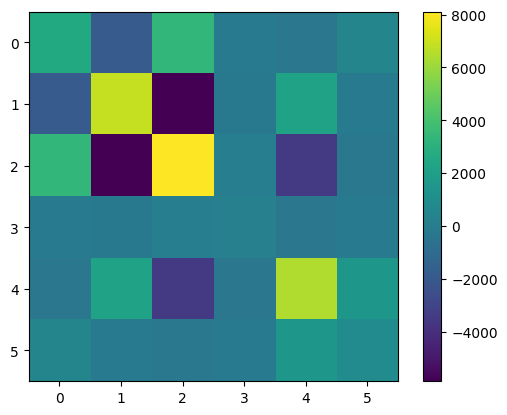

In [73]:
plt.imshow(F_pred[59])
plt.colorbar()

In [97]:
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [98]:
outdir = "/data80/makinen/degenerate_fishnets/saturation_test/"

mle_preds_all = []
F_preds_all = []

for i,w_i in enumerate(trained_weights):
    
    n_data = n_training_data[i]
    
    fn = lambda d: get_mle_F(d, w=w_i)
    mle_pred,F_pred = jax.vmap(fn)(data.reshape(-1, specshape)[:])
    
    mle_preds_all.append(mle_pred)
    F_preds_all.append(F_pred)
    
    np.save(outdir + "mle_pred_ndata_%d"%(n_data), mle_pred)
    np.save(outdir + "F_pred_ndata_%d"%(n_data), F_pred)
    
    save_obj(w_i, outdir + "network_w_ndata_%d"%(n_data))

In [32]:

save_obj(losses, outdir + "full_k_losses")
save_obj(w, outdir + "full_k_network_w")

np.save(outdir + "full_k_mle_pred", mle_pred)
np.save(outdir + "full_k_F_pred", F_pred)

In [33]:
# load stuff
outdir = "/data80/makinen/degenerate_fishnets/"

mle_pred = np.load(outdir + "full_k_mle_pred.npy")
F_pred = np.load(outdir + "full_k_F_pred.npy")

trained_w = load_obj(outdir + "full_k_network_w.pkl")

In [34]:
theta_true = theta_.reshape(-1, 6)[-3000:]

In [92]:
from chainconsumer import ChainConsumer


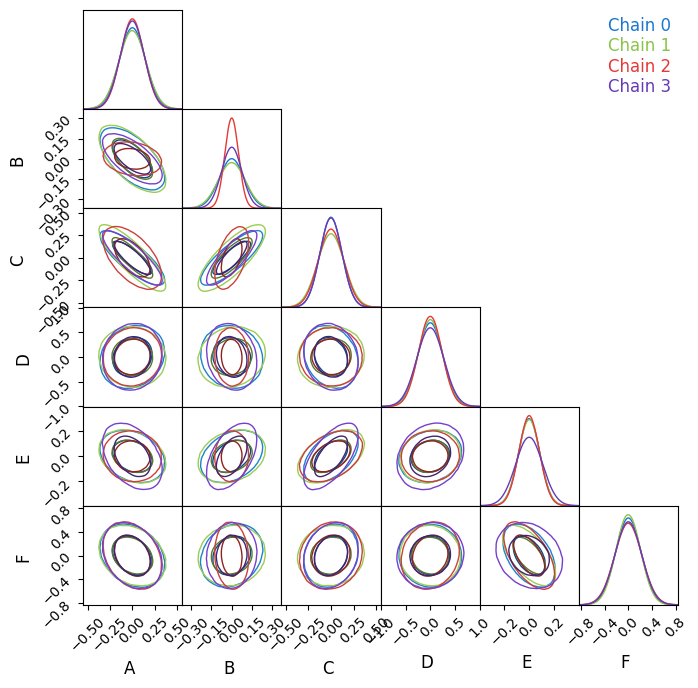

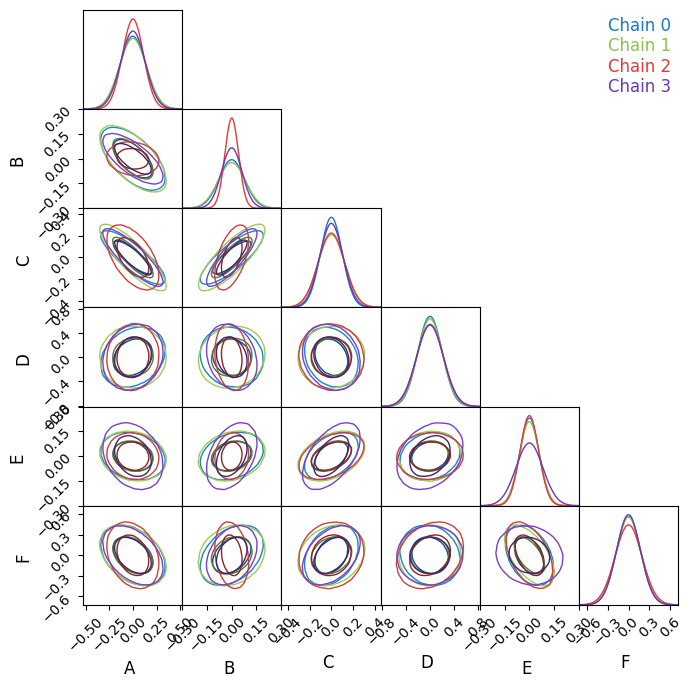

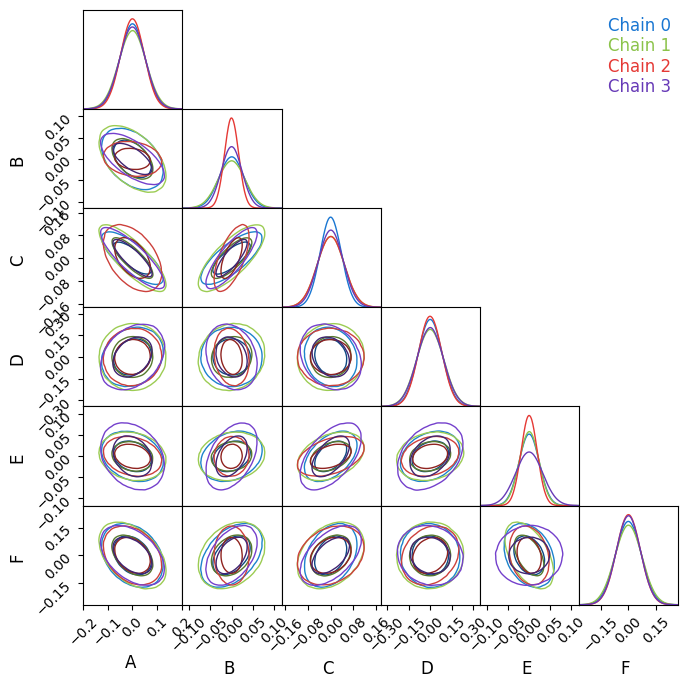

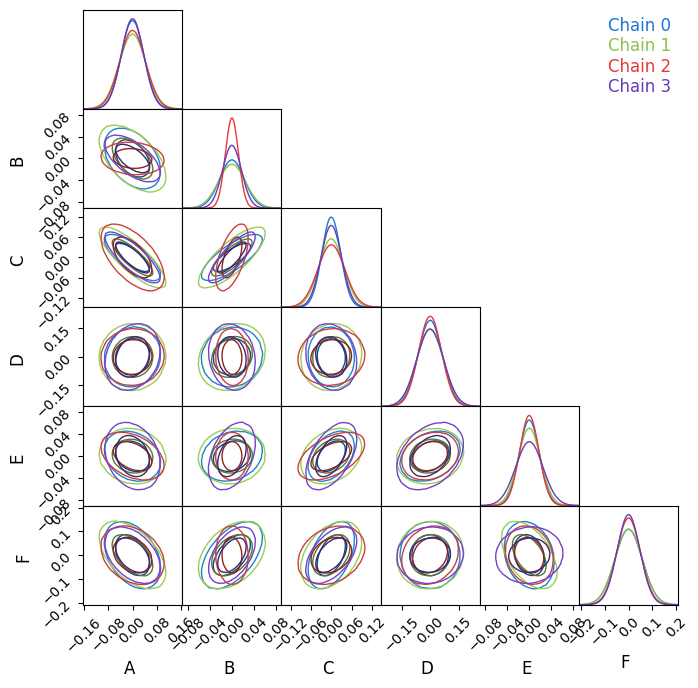

In [76]:
for j,Fpred in enumerate(F_preds):
    cs = ChainConsumer()

    for i in [3, 59, 300, 2000]:


        cs.add_covariance(np.zeros((6,)), np.linalg.inv(Fpred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F']) #, color=corner_colors[0])

            #cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
            #        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)

    cs.plotter.plot((7,7))

    plt.show()

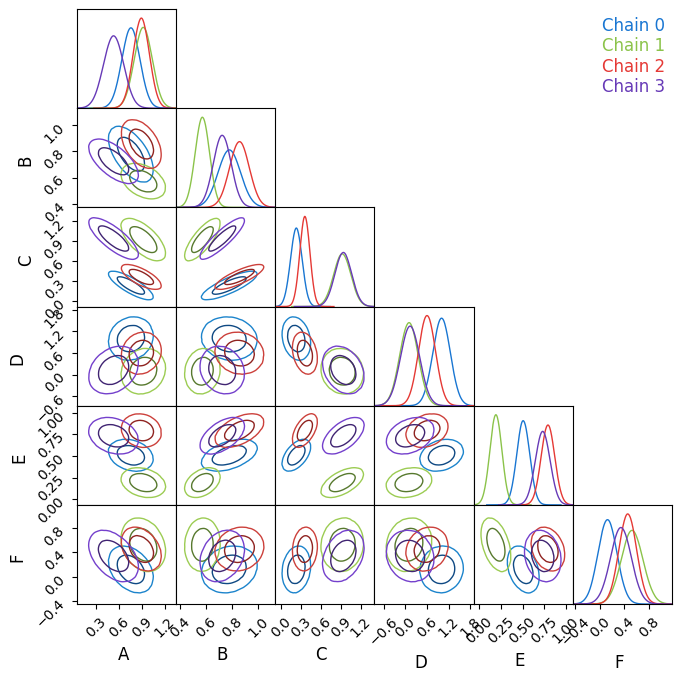

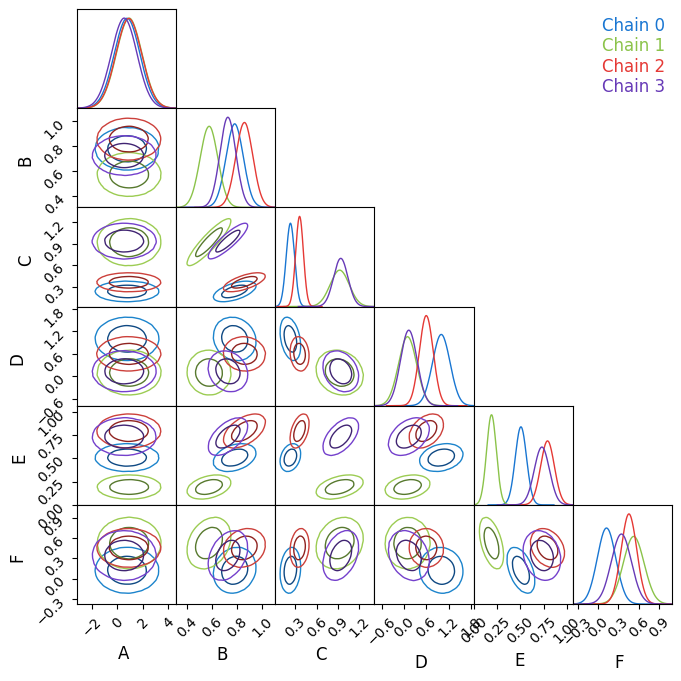

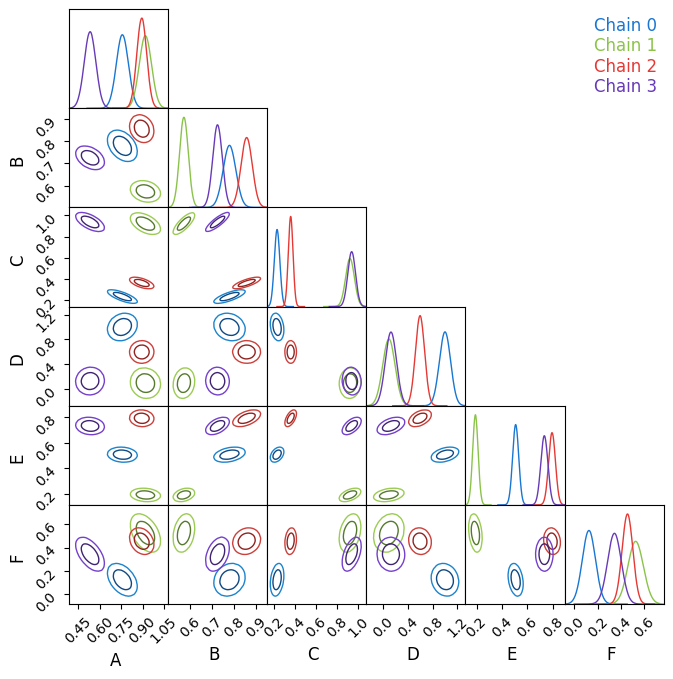

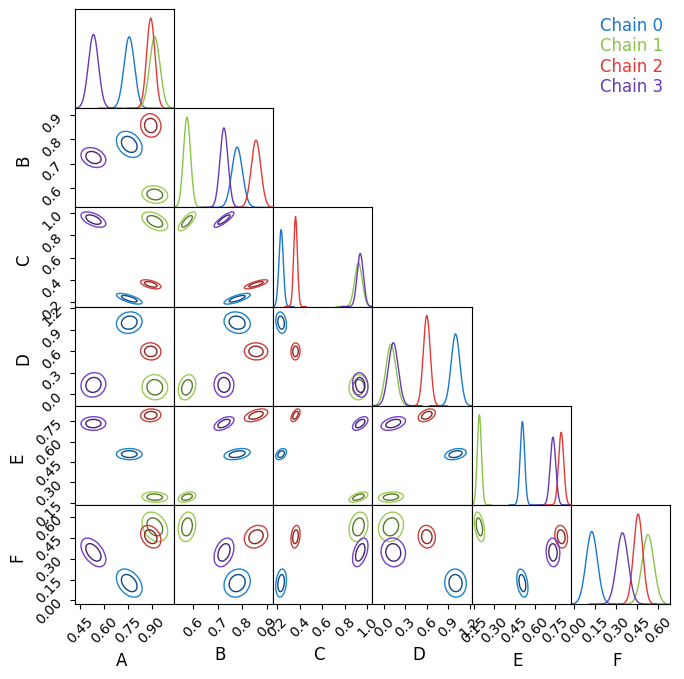

In [93]:
for j,Fpred in enumerate(F_preds):

    cs = ChainConsumer()

    for i in [3, 59, 300, 2000]:


        cs.add_covariance(theta_test[i], np.linalg.inv(Fpred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F']) #, color=corner_colors[0])

            #cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
            #        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)

    cs.plotter.plot((7,7))

    plt.show()

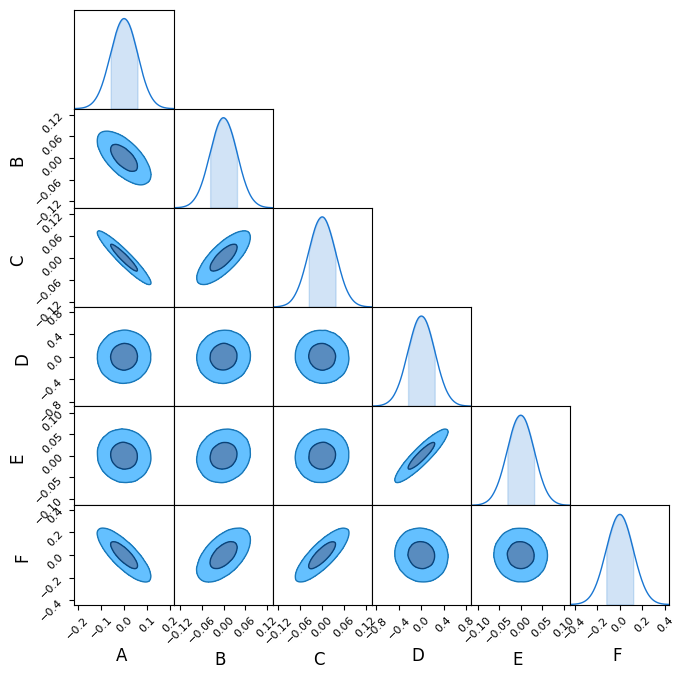

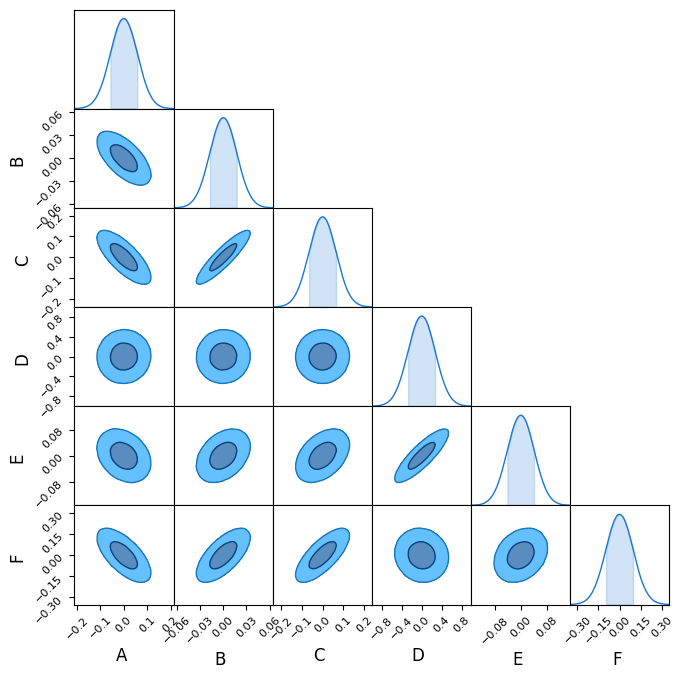

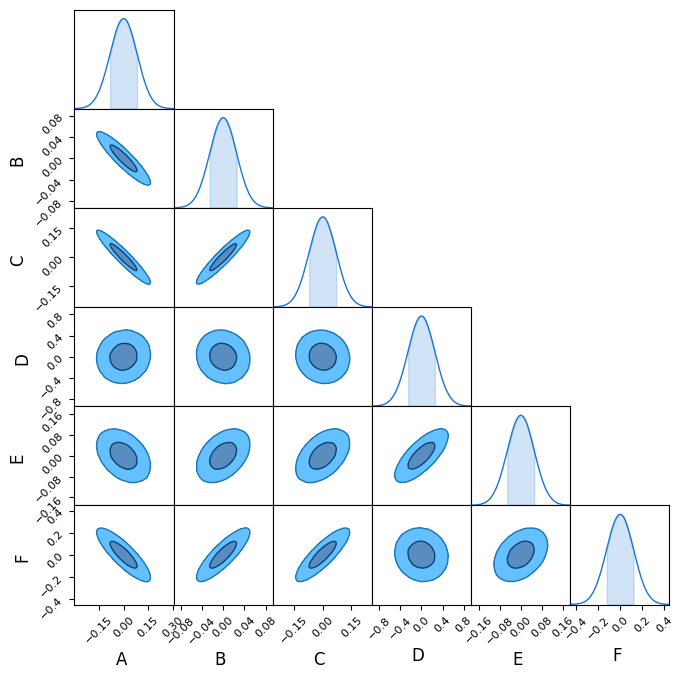

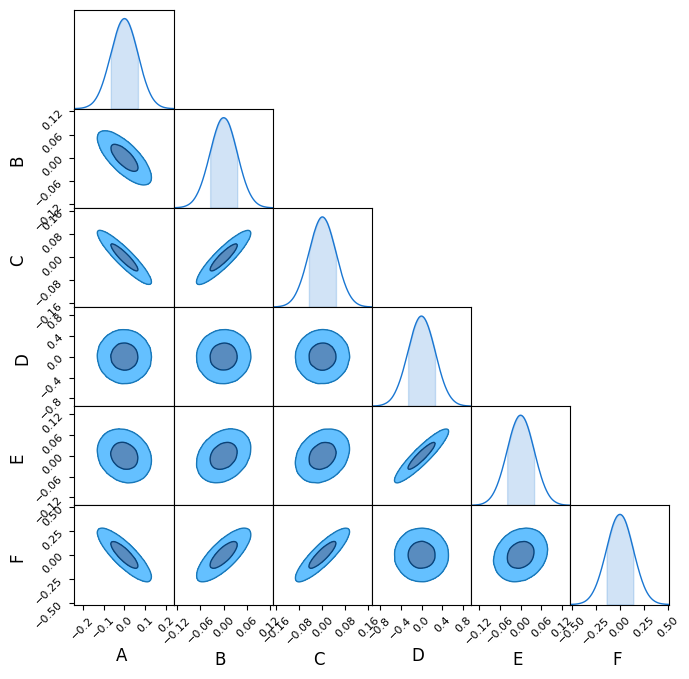

In [19]:
for i in [3, 59, 300, 2000]:

        cs = ChainConsumer()
        cs.add_covariance(np.zeros((6,)), np.linalg.inv(F_pred[i]), parameters=['A', 'B', 'C', 'D', 'E', 'F'], name='fishnets') #, color=corner_colors[0])



        cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
                shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
        cs.plotter.plot((7,7))
        plt.show()

In [ ]:
# load network to predict over rest of data